In [1]:
!unzip Flower.zip

Archive:  Flower.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
 extracting: test/11jpeg_jpeg.rf.fabbd16691f8416d175ff9dfa5a96932.jpg  
 extracting: test/15_jpeg.rf.35e79ed3fe6935db1cd1f26b82a07c2f.jpg  
 extracting: test/17_jpeg.rf.a6c9f0ebb5a7158005c38a876e8aefdb.jpg  
 extracting: test/20_jpeg.rf.8d8ba62060724f61777a7aac9fb4d285.jpg  
 extracting: test/25_jpeg.rf.5343bae2e48c0cb9cbc4a1d6a9d15d61.jpg  
 extracting: test/33_jpeg.rf.1f2d516fbd6b16e4dc7b336956fa1dd5.jpg  
 extracting: test/34_jpeg.rf.224bd8c59928643f732196d3f2d3d9b0.jpg  
 extracting: test/36_jpeg.rf.6d3140a96f3bcd2a1c557ebbc4d8b1c7.jpg  
 extracting: test/37_jpeg.rf.a3170ec3cb2ed5ac9eec12971db67978.jpg  
  inflating: test/_classes.csv       
   creating: train/
 extracting: train/10_jpeg.rf.435ca716d5287a4cd3cdf4546b1555d4.jpg  
 extracting: train/10_jpeg.rf.4861094130d0b0c3df9587022f276c34.jpg  
 extracting: train/10_jpeg.rf.53d3ff6a739f9a3a61400805a662768c.jpg  
 ex

In [1]:
import tensorflow as tf
import pandas as pd
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

In [3]:
df = pd.read_csv('/content/valid/_classes.csv')
df.head(10)

,filename,Daisy,Lily,Rose,Sunflower
0,3_jpeg.rf.5fd675a537becc26f911cc4fdd565e0b.jpg,1,0,0,0
1,23_jpeg.rf.28daa2b48ff15aa497055142c64bd839.jpg,0,1,0,0
2,37_jpeg.rf.1460131662c13d399e7f619b310370bc.jpg,1,0,0,0
3,15_jpeg.rf.31b921e0033867aab1b205d706170cef.jpg,1,0,0,0
4,35_jpeg.rf.7fde438c04ab0c3c33db7f692f1c39e2.jpg,0,0,1,0
5,35_jpeg.rf.792ed8f1a724c6327e32671aac5b9a85.jpg,1,0,0,0
6,16_jpeg.rf.9e82d73439ea7c7b818559e7b7f062b9.jpg,0,0,1,0
7,35_jpeg.rf.367e8af9a9405fb4318286f24bd0ab3b.jpg,0,0,0,1
8,29_jpeg.rf.ecd205322af7bafa69f87bcbe26f1278.jpg,0,1,0,0
9,22_jpeg.rf.5fb14c32022a2b464124385fd1a8130b.jpg,1,0,0,0


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2)

In [5]:
train_csv = pd.read_csv('/content/train/_classes.csv')
temp = train_csv.drop('filename', axis=1)
train_csv['Flower'] = temp.idxmax(axis=1)
test_csv = pd.read_csv('/content/test/_classes.csv')
temp2 = test_csv.drop('filename', axis=1)
test_csv['Flower'] = temp2.idxmax(axis=1)
valid_csv = pd.read_csv('/content/valid/_classes.csv')
temp3 = valid_csv.drop('filename', axis=1)
valid_csv['Flower'] = temp3.idxmax(axis=1)

In [6]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=train_dir,
    x_col="filename",
    y_col='Flower',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=valid_csv,
    directory=valid_dir,
    x_col="filename",
    y_col='Flower',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=test_dir,
    x_col="filename",
    y_col='Flower',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 128 validated image filenames belonging to 4 classes.
Found 16 validated image filenames belonging to 4 classes.
Found 9 validated image filenames belonging to 3 classes.


In [7]:
class_name = ['Daisy', 'Lily', 'Rose', 'Sunflower']

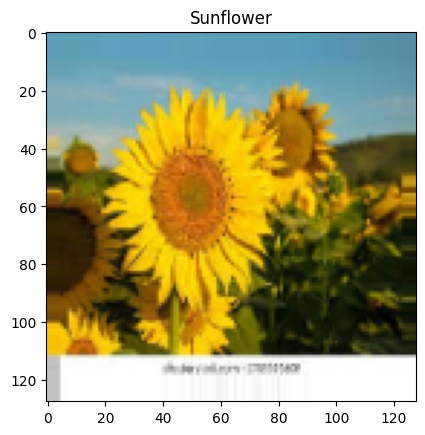

In [8]:
images, labels = next(train_generator)

plt.title(class_name[np.argmax(labels[0])])
plt.imshow(images[0])
plt.show()
# print()

In [9]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size=16, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.projection = layers.Dense(embed_dim)

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        batch_size = tf.shape(images)[0]
        patches = tf.reshape(patches, [batch_size, -1, self.patch_size * self.patch_size * 3])
        return self.projection(patches)

In [10]:
patch_size = 16
def set_seed(seed: int = 42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()
patchify = PatchEmbedding(
                          patch_size=16,
                          embed_dim=768)


## How to calculate this manually??


> ***This is actually have our flatten dim of patches***

N = $\frac{HW}{P^2}$ = $\frac{224*224}{16^2} = 196 $<br><br>
X = $N*(P^2*C)$ =$ 196*(16^2*3) = 150528$



In [11]:
patchify.call(images).shape

TensorShape([32, 64, 768])

In [12]:
class MultiHeadAttention(tf.keras.Model):
  def __init__(self,emb_size:int=768,num_heads:int=12,attn_dropout:float=0):
    super().__init__()

    self.layer_norm = layers.LayerNormalization(axis=-1, epsilon=1e-6)
    self.multihead_attn = layers.MultiHeadAttention(key_dim=emb_size,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout)
  def call(self,x):
      x = self.layer_norm(x)
      x = self.multihead_attn(query=x,value=x,key=x)
      return x

In [13]:
class MLP(tf.keras.Model):
  def __init__(self,emb_size:int=768,mlp_size:int=3072,dropout:float=0.1):
    super().__init__()
    self.layer_norm = layers.LayerNormalization(axis=-1, epsilon=1e-6)
    self.mlp = tf.keras.Sequential([
       layers.Dense(mlp_size,activation='gelu'),
       layers.Dropout(dropout),
       layers.Dense(emb_size)
   ])
  def call(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [14]:
class TransformerEncoder(tf.keras.Model):
  def __init__(self,emb_size:int=768,mlp_size:int=307,num_heads:int=12,attn_dropout:float=0,mlp_dropout:float=0.1):
    super().__init__()
    self.msa_block = MultiHeadAttention(emb_size=emb_size,
                                      num_heads=num_heads,
                                      attn_dropout=attn_dropout)
    self.mlp_block = MLP(emb_size=emb_size,
                         mlp_size=mlp_size,
                         dropout=mlp_dropout)
  def call(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x


In [15]:
patch_embed = PatchEmbedding()
transformer_encoder_block = TransformerEncoder()
input_image = tf.random.normal((1, 128, 128, 3))
patch_embeddings = patch_embed(input_image)
encoded_output = transformer_encoder_block(patch_embeddings)

In [16]:
transformer_encoder_block.build(encoded_output)
transformer_encoder_block.summary()

Model: "transformer_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ multi_head_attention                 │ ?                           │      28,341,504 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mlp (MLP)                            │ ?                           │         474,163 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,815,667 (109.92 MB)

 Trainable params: 28,815,667 (109.92 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
class Vit(tf.keras.Model):
    def __init__(
        self,
        img_size: int = 128,  # Training resolution from Table 3 in ViT paper
        in_channels: int = 3,  # Number of channels in input image
        patch_size: int = 16,  # Patch size
        num_transformer_layers: int = 8,  # Layers from Table 1 for ViT-Base
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        num_heads: int = 8,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,  # Dropout for attention projection
        mlp_dropout: float = 0.1,  # Dropout for dense/MLP layers
        embedding_dropout: float = 0.1,  # Dropout for patch and position embeddings
        num_classes: int = 4  # Number of classes for classification (default is 1000 for ImageNet)
    ):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.num_patches = (img_size * img_size) // (patch_size ** 2)
        self.class_embedding = layers.Embedding(1, embedding_dim)
        self.position_embedding = layers.Embedding(self.num_patches + 1, embedding_dim)
        self.embedding_dropout = layers.Dropout(embedding_dropout)
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, embed_dim=embedding_dim)
        self.transformer_encoder = tf.keras.Sequential([
            TransformerEncoder(emb_size=embedding_dim,
                               mlp_size=mlp_size,
                               num_heads=num_heads,
                               attn_dropout=attn_dropout,
                               mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)
        ])

        self.classification_head = tf.keras.Sequential([
            layers.LayerNormalization(axis=-1, epsilon=1e-6),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        class_embedding = self.class_embedding(tf.zeros((batch_size, 1), dtype=tf.int32))
        x = self.patch_embedding(x)
        x = tf.concat([class_embedding, x], axis=1)
        x = x + self.position_embedding(tf.range(self.num_patches + 1))
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classification_head(x[:, 0])
        return x

vit = Vit(num_classes=len(class_name))


In [18]:
vit = Vit(num_classes=len(class_name))

In [19]:
vit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = vit.fit(train_generator, epochs=60, validation_data=valid_generator)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2385 - loss: 8.7935 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 828ms/step - accuracy: 0.2333 - loss: 12.3572 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 811ms/step - accuracy: 0.2250 - loss: 12.4915 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 838ms/step - accuracy: 0.2708 - loss: 11.7528 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step - accuracy: 0.2448 - loss: 12.1725 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 846ms/step - accuracy: 0.2750 - loss: 11.6856 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 819ms/step - accuracy: 0.2396 - loss: 12.2565 - val_accuracy: 0.3125 - val_loss: 11.0812
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 843ms/step - accuracy: 0.2979 - loss: 11.3162 - val_accuracy: 0.3125 - val_los